# Subscriptions API - Sentinel Hub Hosting

In [392]:
import datetime
import geopandas as gpd
import numpy as np
import pandas as pd
import asyncio
import json
import copy
import os

# Planet Python SDK
from planet import Auth
from planet import Session
from planet.clients.subscriptions import SubscriptionsClient

# Sentinel Hub Python Library
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    SHConfig,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    MimeType,
)

from ipyleaflet import Map, GeoData, basemaps, LayersControl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

In [290]:
aois_file_path = "fields.geojson"

agriculture_fields = gpd.read_file(aois_file_path)

center = (43.67, -81.08)     

m = Map(center=center, zoom = 14, basemap= basemaps.Esri.WorldImagery)

geo_data = GeoData(geo_dataframe = agriculture_fields,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Agriculture Fields')

m.add_layer(geo_data)
m.add_control(LayersControl())

display(m)

Map(center=[43.67, -81.08], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

## Create PlanetScope Subscriptions

In [6]:
# Subscriptions API endpoint
# subscriptions_endpoint = "https://api.planet.com/subscriptions/v1/"

# Template Subscriptions API payload that we will use to create our subscriptions
payload_template = {
    "name": "",
    "source": {
        "type": "catalog",
        "parameters": {
            "asset_types": ["ortho_analytic_8b_sr", "ortho_analytic_8b_xml", "ortho_udm2"],
            "item_types": ["PSScene"],
            "start_time": "",
            "end_time": "",
            "geometry": {},
        },
    },
    "hosting": {"type": "sentinel_hub", "parameters": {"collection_id": ""}},
}

# Set up authentication
pl_api_key = os.getenv("PL_API_KEY")
auth = Auth.from_key(pl_api_key)

In [7]:
# Here we will define functions that will facilitate creating the subscriptions

# This function creates a Subscription API payload for a given area of interest and time range
def create_subscription_payload(
    start_date,
    end_date,
    geojson,
    subscription_name,
    collection_id=None,
):
    logging.info(f"Creating payload for subscription: {subscription_name}")
    start_date_string = start_date.strftime("%Y-%m-%dT00:00:00Z")
    end_date_string = end_date.strftime("%Y-%m-%dT23:59:59Z")

    payload = copy.deepcopy(payload_template)
    payload["name"] = subscription_name

    if collection_id:
        payload["hosting"]["parameters"]["collection_id"] = collection_id
    else:
        payload["hosting"].pop("parameters", None)

    payload["source"]["parameters"]["geometry"] = geojson
    payload["source"]["parameters"]["start_time"] = start_date_string
    payload["source"]["parameters"]["end_time"] = end_date_string

    return payload

In [84]:
# Set up variables for creating the subscriptions

# Define a start and end time
start_date = datetime.date(2023, 1, 1)
end_date = datetime.date(2024, 4, 30)

# Set a collection ID, or set it to None and the function will a create a new collection
collection_id = None # "insert-collection-id-for-pre-existing"

# Open the geojson file with the AOIs
with open(aois_file_path, 'r') as file:
    data = json.load(file)

# Create variables to name the subscriptions
# File name for the input AOIs
base_filename = os.path.splitext(os.path.basename(aois_file_path))[0]
# Incrementor to count the number of subscriptions created
incrementor = 1

In [14]:
# List of subscriptions created
subscriptions = []

async with Session(auth=auth) as sess:

    cl = SubscriptionsClient(sess)

    #For each feature in our geojson feature collection
    for feature in data['features']:

        # Create a name for the subscription
        subscription_name = f"{base_filename}_{incrementor}_PlanetScope"
        
        # Create the payload
        payload = create_subscription_payload(
            start_date = start_date,
            end_date = end_date,
            geojson = feature['geometry'],
            subscription_name = subscription_name,
            collection_id = collection_id,
        )
        # Create the subscription
        results = await cl.create_subscription(payload)
        subscription_id = results["id"]
        subscriptions.append(subscription_id)
        
        # If no collection ID is set, set the collection ID as the collection created for the first subscription that is created
        if not collection_id:
            results = await cl.get_subscription(subscription_id=subscription_id)
            collection_id = results["hosting"]["parameters"]["collection_id"]
            await asyncio.sleep(3) # delay so collection can be established

        incrementor += 1

    print("{} Subscriptions created!".format(len(subscriptions)))

2024-04-09 15:40:44,596 - INFO - Session read timeout set to 30.0.
2024-04-09 15:40:45,018 - INFO - Creating payload for subscription: fields_1_PlanetScope
2024-04-09 15:40:45,018 - INFO - POST https://api.planet.com/subscriptions/v1 - Sent
2024-04-09 15:40:47,998 - INFO - HTTP Request: POST https://api.planet.com/subscriptions/v1 "HTTP/1.1 200 OK"
2024-04-09 15:40:48,003 - INFO - POST https://api.planet.com/subscriptions/v1 - Status 200
2024-04-09 15:40:48,011 - INFO - Creating payload for subscription: fields_2_PlanetScope
2024-04-09 15:40:48,013 - INFO - POST https://api.planet.com/subscriptions/v1 - Sent
2024-04-09 15:40:50,352 - INFO - HTTP Request: POST https://api.planet.com/subscriptions/v1 "HTTP/1.1 200 OK"
2024-04-09 15:40:50,354 - INFO - POST https://api.planet.com/subscriptions/v1 - Status 200
2024-04-09 15:40:50,363 - INFO - Creating payload for subscription: fields_3_PlanetScope
2024-04-09 15:40:50,368 - INFO - POST https://api.planet.com/subscriptions/v1 - Sent
2024-04-0

4 Subscriptions created!


In [411]:
async with Session(auth=auth) as sess:

    cl = SubscriptionsClient(sess)

    statuses = []

    for subscription_id in subscriptions[:10]:
        sub_details = await cl.get_subscription(subscription_id=subscription_id)
        subscription_status = sub_details["status"]
        statuses.append(f"Subscription ID: {subscription_id} ({subscription_status})")

for status in statuses:
    print("------")
    print(status)

2024-04-10 08:20:40,628 - INFO - Session read timeout set to 30.0.
2024-04-10 08:20:41,143 - INFO - GET https://api.planet.com/subscriptions/v1/32cefbff-67e5-416b-a755-b946b7f7390c - Sent
2024-04-10 08:20:41,293 - INFO - HTTP Request: GET https://api.planet.com/subscriptions/v1/32cefbff-67e5-416b-a755-b946b7f7390c "HTTP/1.1 200 OK"
2024-04-10 08:20:41,293 - INFO - GET https://api.planet.com/subscriptions/v1/32cefbff-67e5-416b-a755-b946b7f7390c - Status 200
2024-04-10 08:20:41,303 - INFO - GET https://api.planet.com/subscriptions/v1/9055d97a-f93a-4579-bd7a-f9e8456fdffe - Sent
2024-04-10 08:20:41,330 - INFO - HTTP Request: GET https://api.planet.com/subscriptions/v1/9055d97a-f93a-4579-bd7a-f9e8456fdffe "HTTP/1.1 429 Too Many Requests"
2024-04-10 08:20:41,330 - INFO - GET https://api.planet.com/subscriptions/v1/9055d97a-f93a-4579-bd7a-f9e8456fdffe - Status 429
2024-04-10 08:20:41,338 - INFO - Try 1
2024-04-10 08:20:41,338 - INFO - Retrying: caught <class 'planet.exceptions.TooManyRequests

Subscription ID: 32cefbff-67e5-416b-a755-b946b7f7390c (running)
Subscription ID: 9055d97a-f93a-4579-bd7a-f9e8456fdffe (running)
Subscription ID: 7d762065-40c4-4776-b54b-c4899161e428 (running)
Subscription ID: 18c03f0a-b2dc-4071-9952-492851f9e113 (running)


# Visualize the Data

Here we will use the Sentinel Hub Statistics and Process API to visualize the PlanetScope imagery that we ordered.

In [16]:
# Configure the Sentinel Hub Python package: https://sentinelhub-py.readthedocs.io/en/latest/configure.html

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
else:
    print("Connected to Sentinel Hub")

Connected to Sentinel Hub


In [278]:
data_collection = DataCollection.define_byoc(collection_id)

input_data = SentinelHubStatistical.input_data(data_collection)

# Set a time interval
time_interval = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# Specify a resolution
resx = 3
resy = 3

# Provide an evalscript
evalscript_path = "ndvi_evalscript.js"
with open(evalscript_path, 'r') as file:
    evalscript = file.read()

# Create the requests
aggregation = SentinelHubStatistical.aggregation(
    evalscript=evalscript, time_interval=time_interval, aggregation_interval="P1D", resolution=(resx, resy)
)

histogram_calculations = {"ndvi": {"histograms": {"default": {"nBins": 20, "lowEdge": -1.0, "highEdge": 1.0}}}}

In [279]:
# For each polygon field boundary, create a Statistical API request

agriculture_fields_3857 = agriculture_fields.to_crs(3857)

ndvi_requests = []

for geo_shape in agriculture_fields_3857.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(agriculture_fields_3857.crs)),
        calculations=histogram_calculations,
        config=config,
    )
    ndvi_requests.append(request)

print("{} Statistical API requests prepared!".format(len(ndvi_requests)))
print("\nFirst request: \n")
print(json.dumps(req.payload, indent=4))

4 Statistical API requests prepared!

First request: 

{
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/3857"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -9024835.810479525,
                            5415269.94480405
                        ],
                        [
                            -9024109.640754985,
                            5414859.18213157
                        ],
                        [
                            -9023427.481316837,
                            5416073.132529611
                        ],
                        [
                            -9024138.980945893,
                            5416458.222535042
                        ],
                        [
                            -9024432.38285482,
                      

In [280]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

print("{} Results from the Statistical API!".format(len(ndvi_requests)))

4 Results from the Statistical API!
CPU times: total: 1.14 s
Wall time: 41.9 s


In [281]:
ndvi_dfs = [pd.json_normalize(per_aoi_stats["data"]) for per_aoi_stats in ndvi_stats]

for df, index_value in zip(ndvi_dfs, agriculture_fields.index):
    df["field_id"] = index_value

ndvi_df = pd.concat(ndvi_dfs)

#calculate date as day of the year for time integration
ndvi_df["day_of_year"] = ndvi_df.apply(lambda row: datetime.datetime.fromisoformat(row['interval.from'].rstrip('Z')).timetuple().tm_yday, axis=1)

#ndvi_df["date"] = pd.to_datetime(df['interval.from']).dt.tz_localize(None)
ndvi_df["date"] = pd.to_datetime(ndvi_df['interval.from']).dt.date

del_cols = [i for i in list(ndvi_df) if i not in ["interval.from", "outputs.ndvi.bands.B0.stats.mean", "outputs.ndvi.bands.B1.stats.mean", "day_of_year", "field_id", "date"]]

ndvi_df = ndvi_df.drop(columns=del_cols).rename(columns={'interval_from': 'date', 'outputs.ndvi.bands.B0.stats.mean': 'ndvi_mean', 'outputs.ndvi.bands.B1.stats.mean': 'clouds', 'field_id':'field_id'})

ndvi_df['ndvi_mean'] = ndvi_df['ndvi_mean'].astype(float)
ndvi_df['clouds'] = ndvi_df['clouds'].astype(float)

ndvi_df

,interval.from,ndvi_mean,clouds,field_id,day_of_year,date
0,2023-01-09T00:00:00Z,0.008808,0.000000,0,9,2023-01-09
1,2023-01-15T00:00:00Z,0.172491,1.000000,0,15,2023-01-15
2,2023-01-16T00:00:00Z,0.170023,0.999768,0,16,2023-01-16
3,2023-01-24T00:00:00Z,-0.006101,0.000000,0,24,2023-01-24
4,2023-01-27T00:00:00Z,-0.035869,0.244796,0,27,2023-01-27
...,...,...,...,...,...,...
221,2024-03-29T00:00:00Z,0.034996,0.000000,3,89,2024-03-29
222,2024-03-30T00:00:00Z,0.334601,0.673334,3,90,2024-03-30
223,2024-03-31T00:00:00Z,0.039860,0.000000,3,91,2024-03-31
224,2024-04-07T00:00:00Z,0.460379,1.000000,3,98,2024-04-07


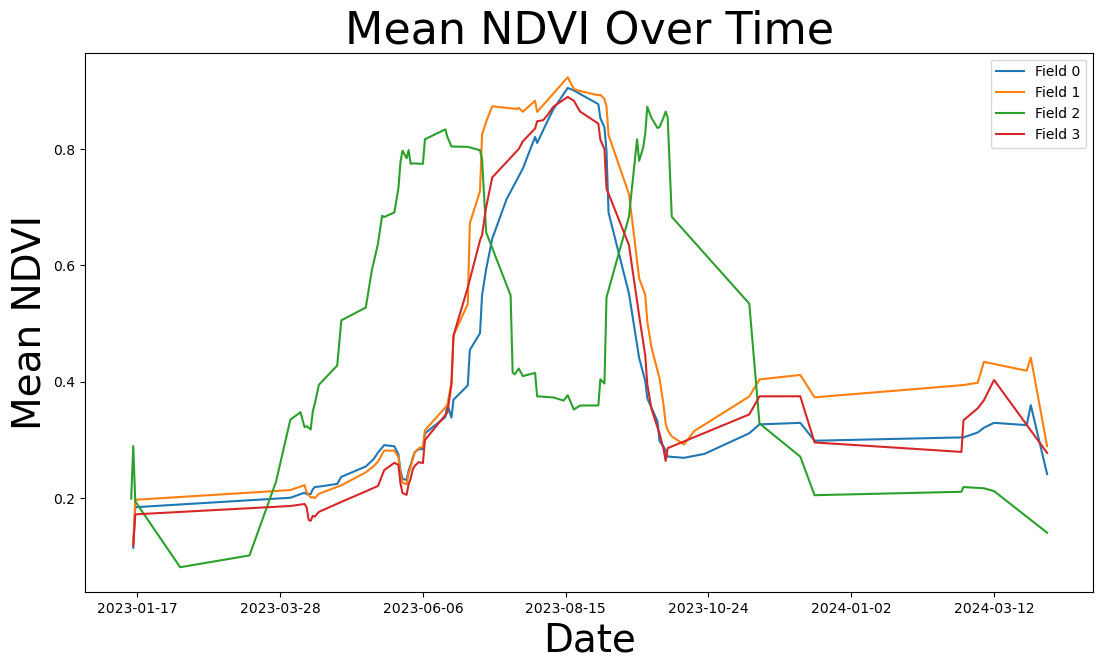

In [405]:
pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(13, 7))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

# Formatting the dates on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Date format
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))  # Show a date every week

for idx, field_id in enumerate(agriculture_fields.index.values):

    series = ndvi_df[(ndvi_df["field_id"] == field_id) & (ndvi_df["clouds"].ge(0.9))]
    
    # Non rolling average option
    # series.plot(ax=ax, x="date", y="ndvi_mean", color=f"C{idx}", label=("Field " + str(field_id)))
    
    # Rolling average option
    rolling_avg = moving_average(series["ndvi_mean"],3)
    series["rolling_avg"] = rolling_avg
    series.plot(ax=ax, x="date", y="rolling_avg", color=f"C{idx}", label=("Field " + str(field_id)))

    
title = ax.set_title('Mean NDVI Over Time', fontsize=32)
ylabel = ax.set_ylabel("Mean NDVI", fontsize=28)
xlabel = ax.set_xlabel("Date", fontsize=28)

### Use Process API to Retrieve Images

In [406]:
# Let's grab certain dates to visualize with the Process API

# Subset the time series to one field where it's >90% clear
one_field = ndvi_df[(ndvi_df["field_id"] == 0) & (ndvi_df["clouds"].ge(0.9))]

# Find the date with the highest NDVI
peak_ndvi_date = one_field.loc[one_field['ndvi_mean'].idxmax(), 'date']

# Calculate a column for date difference from peak NDVI 
one_field['date_diff'] = (one_field['date'] - peak_ndvi_date).abs()

# Find the 5 dates where we have clear imagery closest to the peak NDVI
one_field_sorted = one_field.sort_values(by='date_diff')

unique_acquisitions = one_field_sorted.head(5).sort_values(by="date")['date']

unique_acquisitions_list = unique_acquisitions.to_list()

unique_acquisitions_list

[datetime.date(2023, 8, 1),
 datetime.date(2023, 8, 6),
 datetime.date(2023, 8, 9),
 datetime.date(2023, 8, 16),
 datetime.date(2023, 8, 19)]

In [393]:
# Provide an evalscript to generate true color visualizations
true_color_evalscript = "true_color_evalscript.js"
with open(true_color_evalscript, 'r') as file:
    true_color_evalscript = file.read()

In [394]:
# Create Process API requests for each date

process_requests = []

time_difference = datetime.timedelta(hours=1)

agriculture_field = agriculture_fields_3857.iloc[0]

for timestamp in unique_acquisitions_list:
    request = SentinelHubRequest(
        evalscript=true_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp, timestamp),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        geometry=Geometry(agriculture_field["geometry"], crs=CRS("EPSG:3857")),
        resolution=(3, 3),
        config=config,
    )
    process_requests.append(request)

print("{} Process API requests prepared!".format(len(process_requests)))
print("\nFirst request: \n")
print(json.dumps(request.payload, indent=4))

5 Process API requests prepared!

First request: 

{
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/3857"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            -9024835.810479525,
                            5415269.94480405
                        ],
                        [
                            -9024109.640754985,
                            5414859.18213157
                        ],
                        [
                            -9023427.481316837,
                            5416073.132529611
                        ],
                        [
                            -9024138.980945893,
                            5416458.222535042
                        ],
                        [
                            -9024432.38285482,
                          

In [396]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

CPU times: total: 3.12 s
Wall time: 4.5 s


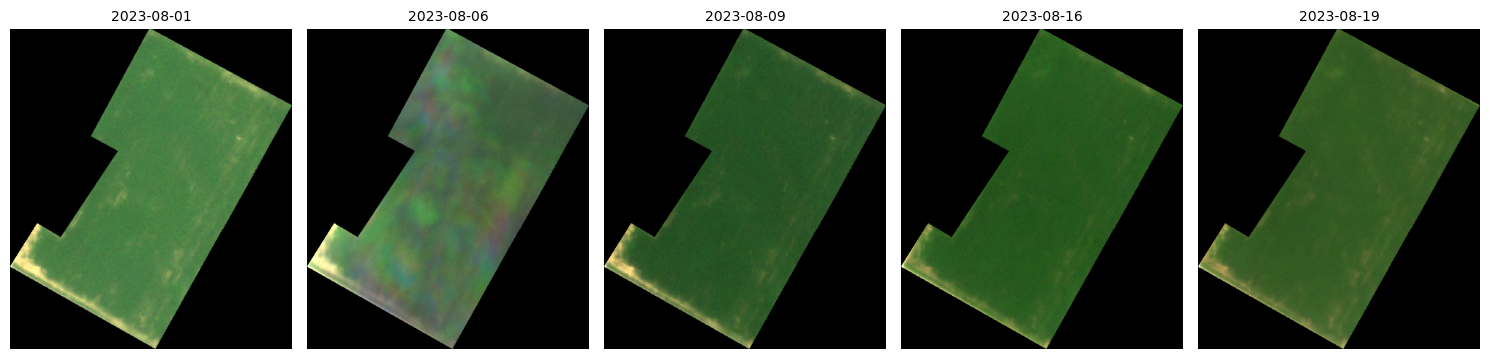

In [397]:
ncols, nrows = 5, 1

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(15, 5),
    subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions_list)):
    ax = axis[idx]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1)) 
    ax.set_title(timestamp.isoformat(), fontsize=10)

plt.tight_layout()
plt.show()

### Create a median NDVI image over 5 nearest clear days

In [400]:
data_collection = DataCollection.define_byoc(collection_id)

input_data = SentinelHubStatistical.input_data(data_collection)

# Specify a resolution
resx = 3
resy = 3

# Provide an evalscript which calculates the median from our range of dates
median_ndvi_evalscript = "median_ndvi_evalscript.js"
with open(median_ndvi_evalscript, 'r') as file:
    median_ndvi_evalscript = file.read()

min_date = unique_acquisitions.min()
max_date = unique_acquisitions.max()
time_interval = min_date.strftime('%Y-%m-%d'), max_date.strftime('%Y-%m-%d')

print(time_interval)

('2023-08-01', '2023-08-19')


In [401]:
request = SentinelHubRequest(
    evalscript=median_ndvi_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=data_collection,
            time_interval=time_interval,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    geometry=Geometry(agriculture_field["geometry"], crs=CRS("EPSG:3857")),
    resolution=(3, 3),
    config=config,
)

image = request.get_data()

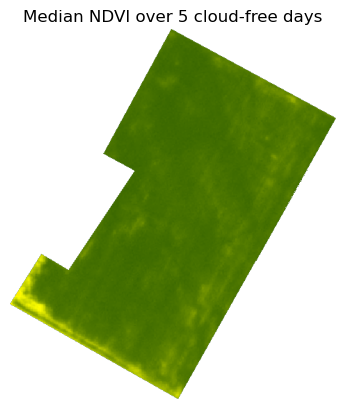

In [402]:
plt.imshow(image[0])
plt.axis('off')  # To not display axis
plt.title("Median NDVI over 5 cloud-free days")
plt.show()